In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score

In [2]:
def load_and_explore(train_path, test_path):
    """
    Load the Titanic dataset and perform exploratory data analysis.
    """
    # Load the data
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Check for missing values
    print("Missing values in training data:")
    print(train_data.isnull().sum())
    
    # Plot survival distribution
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Survived', data=train_data)
    plt.title('Survival Distribution')
    plt.show()
    
    # Plot age distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data['Age'], bins=30, kde=True)
    plt.title('Age Distribution')
    plt.show()
    
    # Plot survival by gender
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Sex', hue='Survived', data=train_data)
    plt.title('Survival by Gender')
    plt.show()
    
    # Plot survival by embarkation point
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Embarked', hue='Survived', data=train_data)
    plt.title('Survival by Embarkation Point')
    plt.show()
    
    return train_data, test_data

In [3]:
def clean_and_transform(train_df, test_df):
     """
    Clean and transform the Titanic dataset.
    
    Args:
    train_df (pd.DataFrame): Training data
    test_df (pd.DataFrame): Test data
    
    Returns:
    tuple: Cleaned and transformed train and test DataFrames
    """
    # Store the 'Survived' column from train_df
    train_survived = train_df['Survived']
    
    # Combine train and test data for preprocessing
    combined_data = pd.concat([train_df.drop('Survived', axis=1), test_df], sort=False)
    
    # Fill missing values
    combined_data['Age'].fillna(combined_data['Age'].mean(), inplace=True)
    combined_data['Embarked'].fillna(combined_data['Embarked'].mode()[0], inplace=True)
    combined_data['Fare'].fillna(combined_data['Fare'].median(), inplace=True)
    
    # Drop unnecessary columns
    combined_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    
    # Encode categorical variables
    le = LabelEncoder()
    combined_data['Sex'] = le.fit_transform(combined_data['Sex'])
    combined_data['Embarked'] = le.fit_transform(combined_data['Embarked'])
    
    # Scale numeric features
    scaler = StandardScaler()
    numeric_features = ['Age', 'Fare']
    combined_data[numeric_features] = scaler.fit_transform(combined_data[numeric_features])
    
    # Split back into train and test data
    train_data = combined_data[:len(train_df)]
    test_data = combined_data[len(train_df):]
    
    # Add 'Survived' back to train_data
    train_data['Survived'] = train_survived
    
    return train_data, test_data

In [4]:
def prepare_data(train_data, test_data):
    """
    Prepare the data for model training and prediction.
    
    Args:
    train_data (pd.DataFrame): Cleaned training data
    test_data (pd.DataFrame): Cleaned test data
    
    Returns:
    tuple: X (features), y (target), and X_test (test features)
    """
    # Prepare training data
    X = train_data.drop(['Survived', 'PassengerId'], axis=1)
    y = train_data['Survived']
    
    # Prepare test data
    X_test = test_data.drop(['PassengerId'], axis=1)
    
    # Ensure X and X_test have the same columns
    X = X[X_test.columns]
    
    return X, y, X_test

In [5]:
def train_and_evaluate_models(X, y):
    """
    Train and evaluate multiple models on the Titanic dataset.
    """
    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define models to evaluate
    models = {
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    }
    
    best_model = None
    best_score = 0
    
    # Train and evaluate each model
    for name, model in models.items():
        if name == 'Decision Tree':
            # Perform grid search for Decision Tree
            param_grid = {
                'max_depth': [None, 5, 10, 15],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            grid_search = GridSearchCV(model, param_grid, cv=5)
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            print(f"Best {name} parameters: {grid_search.best_params_}")
        else:
            model.fit(X_train, y_train)
        
        # Make predictions and calculate accuracy
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)
        print(f"{name} Accuracy: {score:.4f}")
        
        # Update best model if current model performs better
        if score > best_score:
            best_score = score
            best_model = model
    
    print(f"\nBest Model: {type(best_model).__name__} with accuracy: {best_score:.4f}")
    return best_model

In [6]:
def generate_submission(model, X_test, test_df):
    """
    Generate a submission file for the Kaggle competition.
    """
    predictions = model.predict(X_test)
    submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': predictions})
    submission.to_csv('titanic_submission.csv', index=False)
    print("Submission file created: titanic_submission.csv")

In [7]:
def titanic_prediction_pipeline():
    """
    Main function to run the Titanic prediction pipeline.
    """
    # Load and explore the data
    train_df, test_df = load_and_explore('titanic_dataset/train.csv', 'titanic_dataset/test.csv')
    
    # Clean and transform the data
    train_data, test_data = clean_and_transform(train_df, test_df)
    
    # Prepare the data for modeling
    X, y, X_test = prepare_data(train_data, test_data)
    
    # Train and evaluate models
    best_model = train_and_evaluate_models(X, y)
    
    # Generate submission file
    generate_submission(best_model, X_test, test_df)

Missing values in training data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64


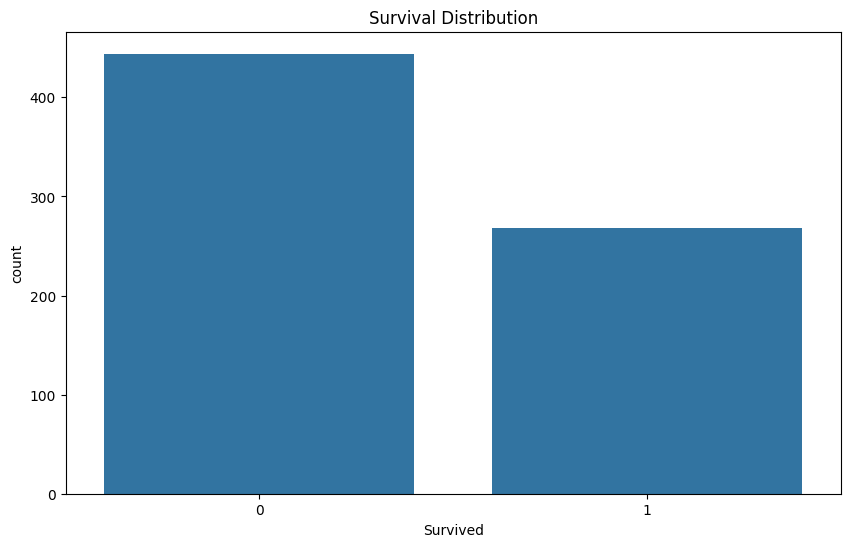

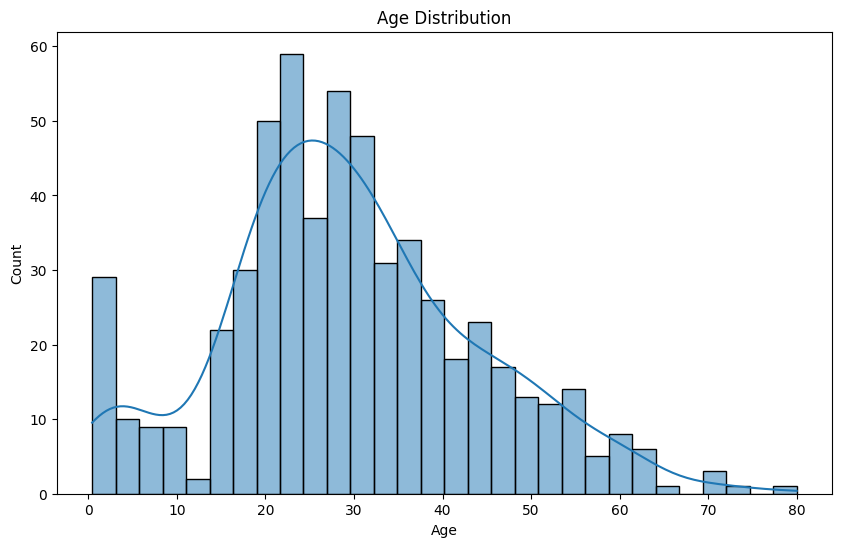

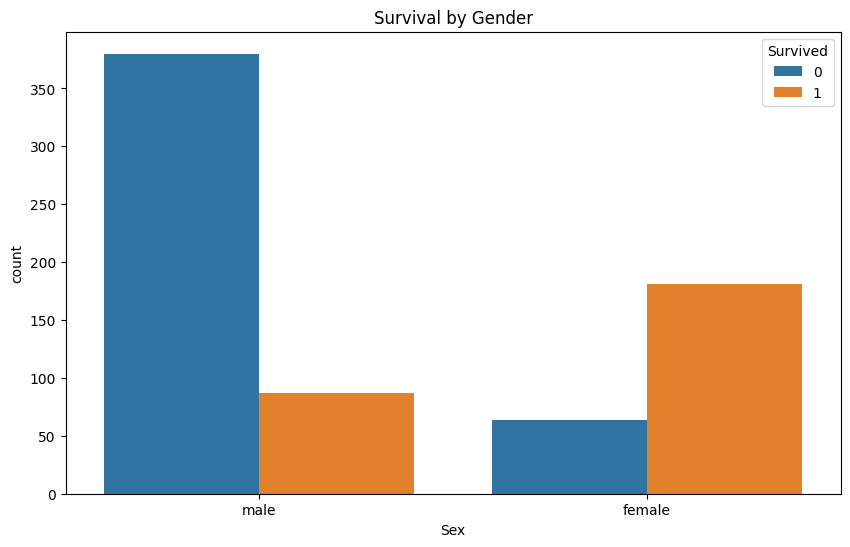

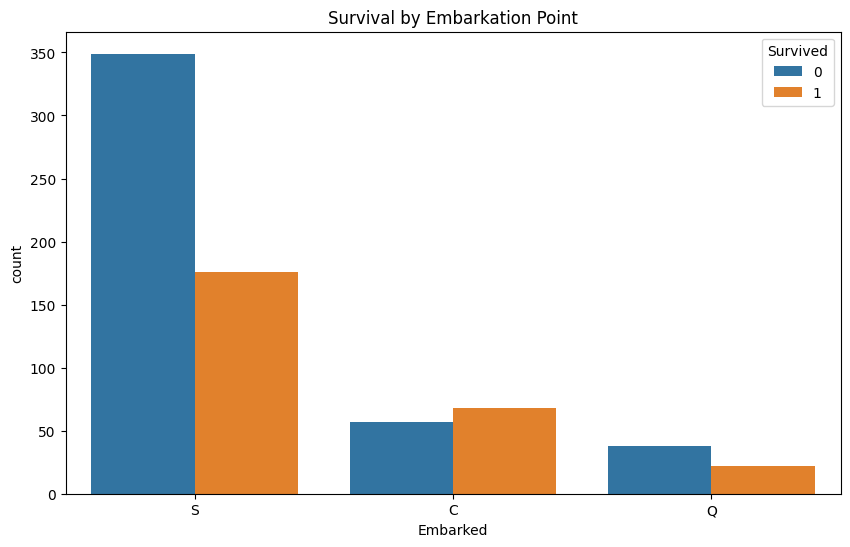

/tmp/ipykernel_34388/273537784.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['Age'].fillna(combined_data['Age'].mean(), inplace=True)
/tmp/ipykernel_34388/273537784.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

Best Decision Tree parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Decision Tree Accuracy: 0.8322
Random Forest Accuracy: 0.8042


/home/jinesh14/CourseWork/MachineLearning/Ass2/mlenv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8112

Best Model: DecisionTreeClassifier with accuracy: 0.8322


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Survived


In [8]:
# Run the Titanic prediction pipeline
if __name__ == "__main__":
    titanic_prediction_pipeline()